In [132]:
# !pip install textstat
# !pip install vaderSentiment

In [134]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re
import textstat
from collections import Counter
from wordcloud import WordCloud
import spacy
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import string
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Data Manipulation

The source dataset can be downloaded using the [link](https://drive.google.com/drive/folders/1mrX3vPKhEzxG96OCPpCeh9F8m_QKCM4z?usp=sharing):

In [ ]:
true_df = pd.read_csv("./data/DataSet_Misinfo_TRUE.csv", index_col=0)
fake_df = pd.read_csv("./data/DataSet_Misinfo_FAKE.csv", index_col=0)

In [4]:
true_df, fake_df

(                                                    text
 0      The head of a conservative Republican faction ...
 1      Transgender people will be allowed for the fir...
 2      The special counsel investigation of links bet...
 3      Trump campaign adviser George Papadopoulos tol...
 4      President Donald Trump called on the U.S. Post...
 ...                                                  ...
 34970  Most conservatives who oppose marriage equalit...
 34971  The freshman senator from Georgia quoted scrip...
 34972  The State Department told the Republican Natio...
 34973  ADDIS ABABA, Ethiopia —President Obama convene...
 34974  Jeb Bush Is Suddenly Attacking Trump. Here's W...
 
 [34975 rows x 1 columns],
                                                     text
 0      Donald Trump just couldn t wish all Americans ...
 1      House Intelligence Committee Chairman Devin Nu...
 2      On Friday, it was revealed that former Milwauk...
 3      On Christmas day, Donald Trump anno

In [5]:
true_df.shape, fake_df.shape

((34975, 1), (43642, 1))

### 1. Check missing values and duplicates

In [6]:
def process_df(df: pd.DataFrame) -> pd.DataFrame:
    """
    Process the DataFrame by removing NaN values and duplicates.
    Args:
        df (pd.DataFrame): The DataFrame to process.
    Returns:
        pd.DataFrame: The cleaned DataFrame.
    """
    
    nan_count = int(df.isna().sum()["text"])
    duplicate_count = df.duplicated().sum()
    df = df.dropna()
    df = df.drop_duplicates()
    print(
        f"{nan_count} NaN, {duplicate_count} duplicate in the provided DataFrame. Have cleaned them all up."
    )
    return df

In [7]:
true_df = process_df(true_df)

29 NaN, 448 duplicate in the provided DataFrame. Have cleaned them all up.


In [8]:
fake_df = process_df(fake_df)

0 NaN, 9564 duplicate in the provided DataFrame. Have cleaned them all up.


In [9]:
true_df.shape[0] + fake_df.shape[0]

68604

### 2. Data processing

In [10]:
tmp_true_df = true_df.copy()
tmp_fake_df = fake_df.copy()

In [11]:
def preprocess_text(text):
    """
    Preprocess the text.
    Args:
        text (str): The text to preprocess.
    Returns:
        str: The preprocessed text.
    """
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    return text

In [12]:
tmp_true_df['text'] = tmp_true_df['text'].apply(preprocess_text)
tmp_fake_df['text'] = tmp_fake_df['text'].apply(preprocess_text)

In [13]:
tmp_true_df

,text
0,The head of a conservative Republican faction ...
1,Transgender people will be allowed for the fir...
2,The special counsel investigation of links bet...
3,Trump campaign adviser George Papadopoulos tol...
4,President Donald Trump called on the U.S. Post...
...,...
34970,Most conservatives who oppose marriage equalit...
34971,The freshman senator from Georgia quoted scrip...
34972,The State Department told the Republican Natio...
34973,"ADDIS ABABA, Ethiopia —President Obama convene..."


In [14]:
tmp_fake_df

,text
0,Donald Trump just couldn t wish all Americans ...
1,House Intelligence Committee Chairman Devin Nu...
2,"On Friday, it was revealed that former Milwauk..."
3,"On Christmas day, Donald Trump announced that ..."
4,Pope Francis used his annual Christmas Day mes...
...,...
44421,"Apparently, the new Kyiv government is in a hu..."
44422,The USA wants to divide Syria.\r\n\r\nGreat Br...
44423,The Ukrainian coup d'etat cost the US nothing ...
44424,The European Parliament falsifies history by d...


# Descriptive Statistics

### 1. Lexical Analysis

In [ ]:
def create_lexical_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create lexical features for the DataFrame.
    The function calculates various lexical features such as word count, sentence count,
    average sentence length, total word length, average word length, punctuation count,
    stop words count, and uppercase count.
    Args:
        df (pd.DataFrame): The DataFrame containing the text data.
    Returns:
        pd.DataFrame: The DataFrame with added lexical features.
    """
    
    def count_words(text):
        return len(word_tokenize(text))

    def count_sentences(text):
        return len(sent_tokenize(text))

    def count_punctuation(text):
        return sum(1 for char in text if char in string.punctuation)

    stop_words = set(stopwords.words("english"))

    def count_stop_words(text):
        return sum(1 for word in word_tokenize(text) if word.lower() in stop_words)

    df.loc[:, "char_count"] = df["text"].apply(len)
    df.loc[:, "word_count"] = df["text"].apply(count_words)
    df.loc[:, "sentence_count"] = df["text"].apply(count_sentences)
    df.loc[:, "average_sentence_length"] = df["word_count"] / df["sentence_count"]
    df.loc[:, "total_word_length"] = df["text"].apply(
        lambda text: sum(len(word) for word in word_tokenize(text))
    )
    df.loc[:, "average_word_length"] = df["total_word_length"] / df["word_count"]
    df.loc[:, "punctuation_count"] = df["text"].apply(count_punctuation)
    df.loc[:, "stop_words_count"] = df["text"].apply(count_stop_words)
    df.loc[:, "uppercase_count"] = df["text"].apply(lambda text: sum(1 for char in text if char.isupper()))

    return df

In [17]:
tmp_true_df = create_lexical_features(tmp_true_df)
tmp_fake_df = create_lexical_features(tmp_fake_df)

In [18]:
tmp_true_df

,text,char_count,word_count,sentence_count,average_sentence_length,total_word_length,average_word_length,punctuation_count,stop_words_count,uppercase_count
0,The head of a conservative Republican faction ...,4635,880,30,29.333333,3887,4.417045,115,303,144
1,Transgender people will be allowed for the fir...,2537,450,13,34.615385,2142,4.760000,40,171,72
2,The special counsel investigation of links bet...,2765,518,17,30.470588,2304,4.447876,44,201,106
3,Trump campaign adviser George Papadopoulos tol...,2437,432,16,27.000000,2065,4.780093,48,153,99
4,President Donald Trump called on the U.S. Post...,5172,982,40,24.550000,4313,4.392057,132,348,182
...,...,...,...,...,...,...,...,...,...,...
34970,Most conservatives who oppose marriage equalit...,1822,336,15,22.400000,1530,4.553571,37,113,50
34971,The freshman senator from Georgia quoted scrip...,2212,439,16,27.437500,1836,4.182232,57,161,81
34972,The State Department told the Republican Natio...,4076,726,27,26.888889,3415,4.703857,98,251,148
34973,"ADDIS ABABA, Ethiopia —President Obama convene...",6991,1313,40,32.825000,5850,4.455446,156,468,234


In [19]:
tmp_fake_df

,text,char_count,word_count,sentence_count,average_sentence_length,total_word_length,average_word_length,punctuation_count,stop_words_count,uppercase_count
0,Donald Trump just couldn t wish all Americans ...,2893,599,28,21.392857,2378,3.969950,121,205,138
1,House Intelligence Committee Chairman Devin Nu...,1898,331,11,30.090909,1590,4.803625,39,126,88
2,"On Friday, it was revealed that former Milwauk...",3574,686,25,27.440000,2975,4.336735,143,238,307
3,"On Christmas day, Donald Trump announced that ...",2681,506,14,36.142857,2207,4.361660,97,175,109
4,Pope Francis used his annual Christmas Day mes...,2346,458,19,24.105263,1913,4.176856,40,209,63
...,...,...,...,...,...,...,...,...,...,...
44421,"Apparently, the new Kyiv government is in a hu...",167,32,1,32.000000,138,4.312500,2,14,6
44422,The USA wants to divide Syria.\r\n\r\nGreat Br...,403,85,4,21.250000,326,3.835294,14,36,26
44423,The Ukrainian coup d'etat cost the US nothing ...,660,117,5,23.400000,555,4.743590,13,40,38
44424,The European Parliament falsifies history by d...,859,144,8,18.000000,719,4.993056,16,61,28


In [36]:
tmp_true_df.describe()

,char_count,word_count,sentence_count,average_sentence_length,total_word_length,average_word_length,punctuation_count,stop_words_count,uppercase_count
count,34526.000000,34526.000000,34526.000000,34526.000000,34526.000000,34526.000000,34526.000000,34526.000000,34526.000000
mean,3245.023953,620.157765,23.716040,28.430509,2695.837427,4.481963,71.741412,231.177142,102.578723
std,3346.598934,670.205288,29.144919,7.119738,2763.800120,0.345616,83.933943,261.881722,105.845097
min,3.000000,1.000000,1.000000,1.000000,3.000000,1.500000,0.000000,0.000000,0.000000
25%,1109.000000,204.000000,7.000000,24.365156,926.000000,4.264468,21.000000,74.000000,37.000000
50%,2408.000000,442.000000,16.000000,27.861590,2009.000000,4.497809,47.000000,159.000000,76.000000
75%,4397.000000,834.000000,31.000000,31.722222,3656.000000,4.708377,95.000000,309.000000,137.000000
max,85948.000000,17912.000000,1200.000000,354.250000,70677.000000,13.000000,2634.000000,8259.000000,3809.000000


In [37]:
tmp_fake_df.describe()

,char_count,word_count,sentence_count,average_sentence_length,total_word_length,average_word_length,punctuation_count,stop_words_count,uppercase_count
count,34078.000000,34078.000000,34078.000000,34025.000000,34078.000000,34025.000000,34078.000000,34078.000000,34078.000000
mean,2563.479547,482.232467,17.196432,29.504898,2128.900170,4.461542,58.488262,188.361553,96.166207
std,3740.528684,718.775552,31.075133,15.296643,3106.098687,0.503490,91.226392,287.214207,140.342012
min,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,583.000000,110.000000,4.000000,21.147059,485.000000,4.221311,13.000000,36.000000,25.000000
50%,1969.000000,367.000000,12.000000,27.200000,1627.000000,4.443325,41.000000,145.000000,69.000000
75%,3046.000000,572.000000,20.000000,34.500000,2526.000000,4.673740,70.000000,228.000000,115.000000
max,142961.000000,27979.000000,1444.000000,516.571429,122086.000000,47.359375,4482.000000,12284.000000,5000.000000


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

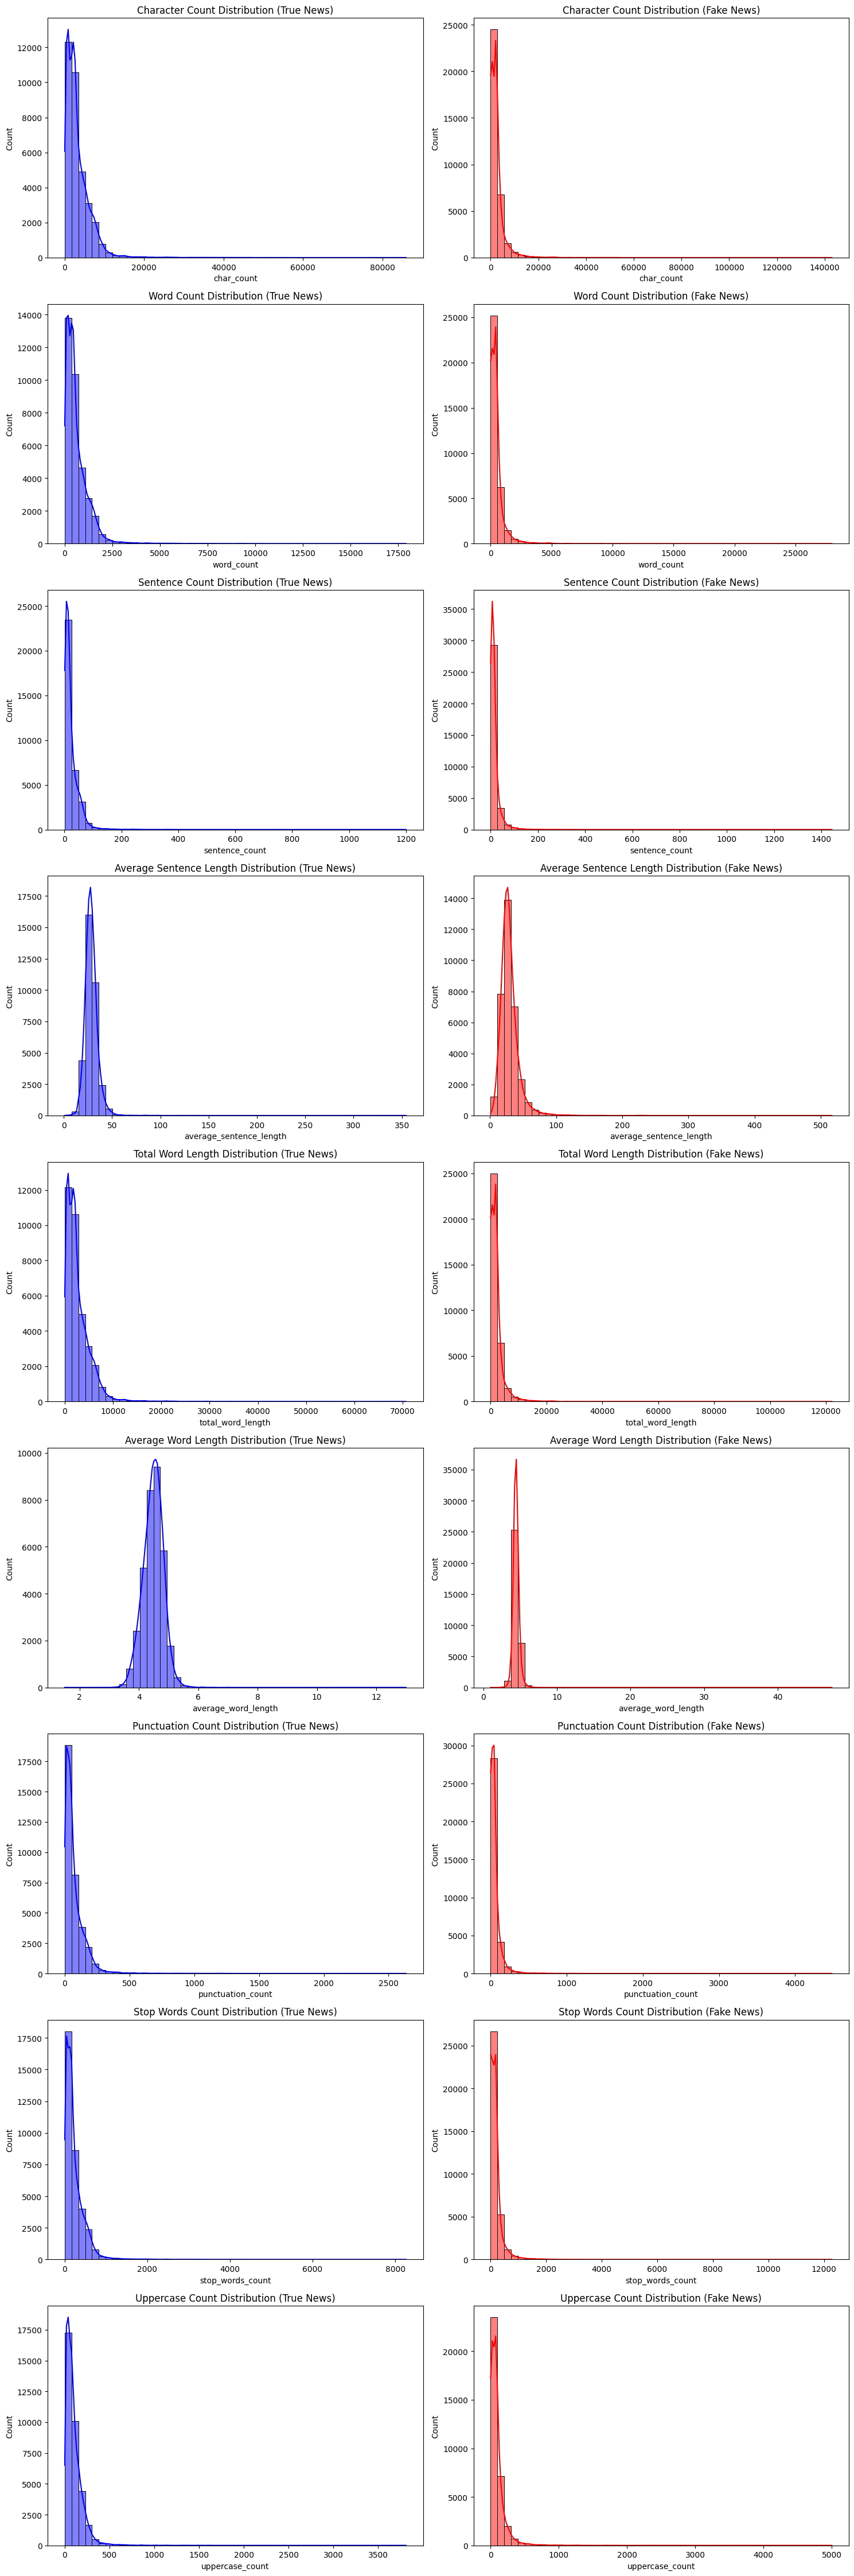

In [41]:
fig, axes = plt.subplots(9, 2, figsize=(15, 45))

columns = [
    'char_count', 'word_count', 'sentence_count', 'average_sentence_length',
    'total_word_length', 'average_word_length', 'punctuation_count',
    'stop_words_count', 'uppercase_count'
]

titles = [
    'Character Count', 'Word Count', 'Sentence Count', 'Average Sentence Length',
    'Total Word Length', 'Average Word Length', 'Punctuation Count',
    'Stop Words Count', 'Uppercase Count'
]

for i, column in enumerate(columns):
    sns.histplot(tmp_true_df[column], bins=50, color='blue', ax=axes[i, 0], kde=True)
    axes[i, 0].set_title(f'{titles[i]} Distribution (True News)')
    sns.histplot(tmp_fake_df[column], bins=50, color='red', ax=axes[i, 1], kde=True)
    axes[i, 1].set_title(f'{titles[i]} Distribution (Fake News)')

plt.tight_layout()
plt.show()

### 2. Readability Score Analysis

- **Flesch-Kincaid Reading Ease**: This score measures the readability of a text based on sentence length and the number of syllables per word. Higher scores indicate easier-to-read text, suitable for a general audience. Lower scores suggest more complex text, requiring higher reading proficiency. Ranges from 0 to 100, with scores above 60 considered easily readable.

- **Gunning Fog Index**: This index evaluates the complexity of a text based on sentence length and the proportion of complex words (words with three or more syllables). The score represents the number of years of education needed to understand the text. Higher scores indicate more difficult text. Ranges from 0 to 20, with scores above 12 indicating complex text.

Comparing the distributions of these scores between the two types of news can help identify differences in writing styles. For example, fake news might be written more simply to spread easily or more complexly to create confusion.

In [42]:
tmp_true_df['flesch_reading_ease'] = true_df['text'].apply(textstat.flesch_reading_ease)
tmp_true_df['gunning_fog'] = true_df['text'].apply(textstat.gunning_fog)

tmp_fake_df['flesch_reading_ease'] = fake_df['text'].apply(textstat.flesch_reading_ease)
tmp_fake_df['gunning_fog'] = fake_df['text'].apply(textstat.gunning_fog)

In [43]:
tmp_true_df

,text,char_count,word_count,sentence_count,average_sentence_length,total_word_length,average_word_length,punctuation_count,stop_words_count,uppercase_count,flesch_reading_ease,gunning_fog
0,The head of a conservative Republican faction ...,4635,880,30,29.333333,3887,4.417045,115,303,144,45.799308,14.012170
1,Transgender people will be allowed for the fir...,2537,450,13,34.615385,2142,4.760000,40,171,72,34.959545,17.587879
2,The special counsel investigation of links bet...,2765,518,17,30.470588,2304,4.447876,44,201,106,46.811050,14.815020
3,Trump campaign adviser George Papadopoulos tol...,2437,432,16,27.000000,2065,4.780093,48,153,99,39.709484,14.930380
4,President Donald Trump called on the U.S. Post...,5172,982,40,24.550000,4313,4.392057,132,348,182,50.333288,12.312534
...,...,...,...,...,...,...,...,...,...,...,...,...
34970,Most conservatives who oppose marriage equalit...,1822,336,15,22.400000,1530,4.553571,37,113,50,45.188750,13.900000
34971,The freshman senator from Georgia quoted scrip...,2212,439,16,27.437500,1836,4.182232,57,161,81,52.839957,12.691653
34972,The State Department told the Republican Natio...,4076,726,27,26.888889,3415,4.703857,98,251,148,45.671838,14.466792
34973,"ADDIS ABABA, Ethiopia —President Obama convene...",6991,1313,40,32.825000,5850,4.455446,156,468,234,42.468269,14.590244


In [44]:
tmp_fake_df

,text,char_count,word_count,sentence_count,average_sentence_length,total_word_length,average_word_length,punctuation_count,stop_words_count,uppercase_count,flesch_reading_ease,gunning_fog
0,Donald Trump just couldn t wish all Americans ...,2893,599,28,21.392857,2378,3.969950,121,205,138,62.715000,10.363443
1,House Intelligence Committee Chairman Devin Nu...,1898,331,11,30.090909,1590,4.803625,39,126,88,45.677700,13.335155
2,"On Friday, it was revealed that former Milwauk...",3574,686,25,27.440000,2975,4.336735,143,238,307,61.637878,10.716580
3,"On Christmas day, Donald Trump announced that ...",2681,506,14,36.142857,2207,4.361660,97,175,109,54.836522,12.498177
4,Pope Francis used his annual Christmas Day mes...,2346,458,19,24.105263,1913,4.176856,40,209,63,62.447143,12.209524
...,...,...,...,...,...,...,...,...,...,...,...,...
44421,"Apparently, the new Kyiv government is in a hu...",167,32,1,32.000000,138,4.312500,2,14,6,41.025000,16.000000
44422,The USA wants to divide Syria.\r\n\r\nGreat Br...,403,85,4,21.250000,326,3.835294,14,36,26,50.875000,16.822222
44423,The Ukrainian coup d'etat cost the US nothing ...,660,117,5,23.400000,555,4.743590,13,40,38,43.252849,14.517736
44424,The European Parliament falsifies history by d...,859,144,8,18.000000,719,4.993056,16,61,28,30.055596,14.794275


In [46]:
tmp_true_df[['flesch_reading_ease', 'gunning_fog']].describe()

,flesch_reading_ease,gunning_fog
count,34526.000000,34526.000000
mean,45.770295,14.893719
std,11.444832,2.887916
min,-132.580000,0.400000
25%,38.831034,13.046670
50%,45.808306,14.814514
75%,52.934137,16.568608
max,121.220000,73.647737


In [47]:
tmp_fake_df[['flesch_reading_ease', 'gunning_fog']].describe()

,flesch_reading_ease,gunning_fog
count,34078.000000,34078.000000
mean,48.579375,13.978245
std,26.852197,3.887678
min,-2078.380000,0.000000
25%,40.791420,11.743689
50%,50.161880,13.757860
75%,58.444434,15.904023
max,121.220000,71.825767


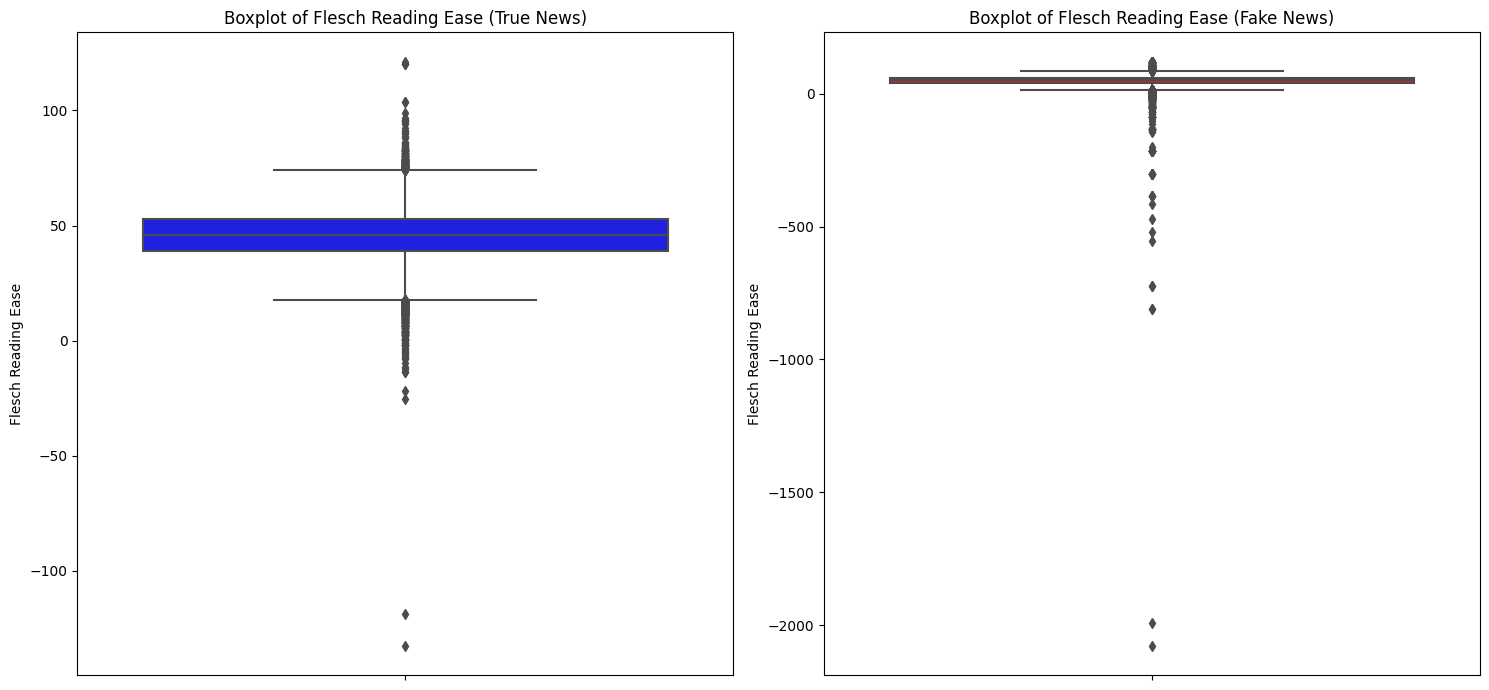

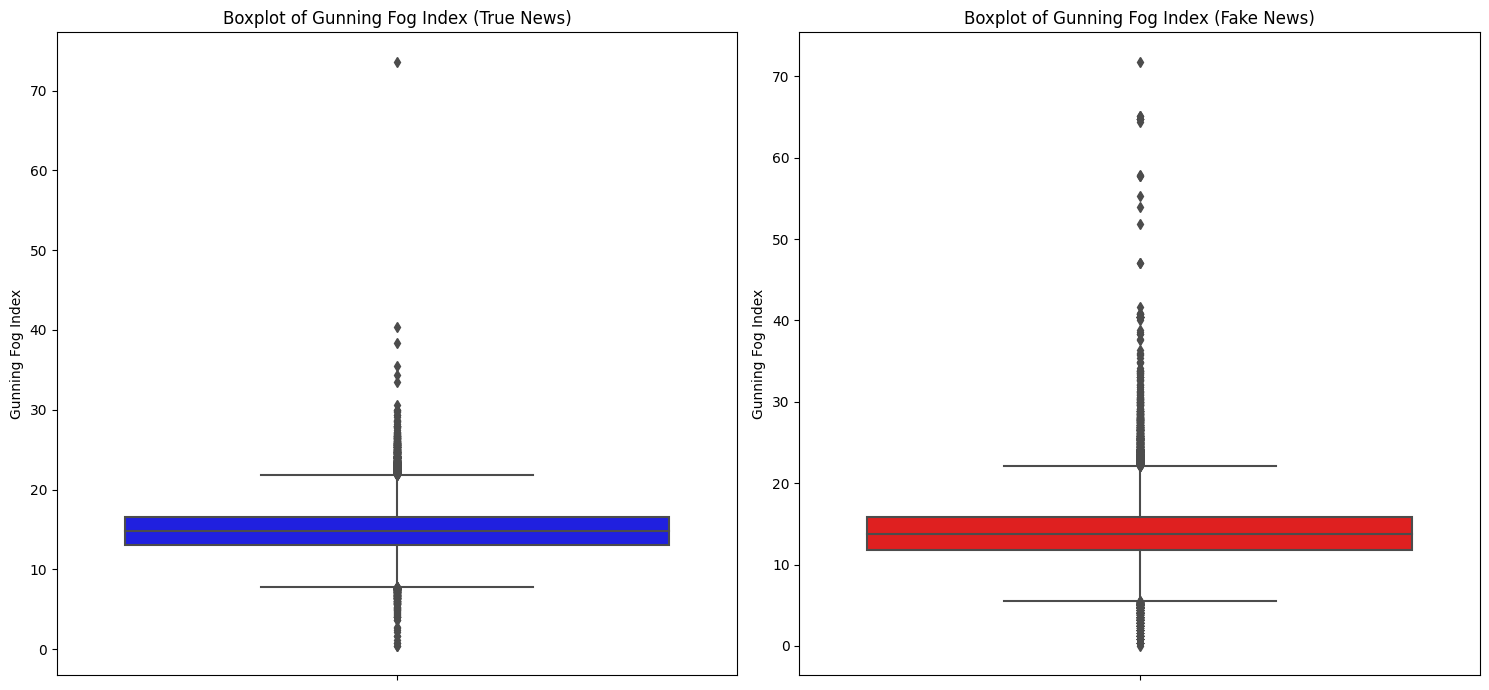

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

sns.boxplot(data=tmp_true_df, y='flesch_reading_ease', ax=axes[0], color='blue')
axes[0].set_title('Boxplot of Flesch Reading Ease (True News)')
axes[0].set_ylabel('Flesch Reading Ease')

sns.boxplot(data=tmp_fake_df, y='flesch_reading_ease', ax=axes[1], color='red')
axes[1].set_title('Boxplot of Flesch Reading Ease (Fake News)')
axes[1].set_ylabel('Flesch Reading Ease')

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(15, 7))

sns.boxplot(data=tmp_true_df, y='gunning_fog', ax=axes[0], color='blue')
axes[0].set_title('Boxplot of Gunning Fog Index (True News)')
axes[0].set_ylabel('Gunning Fog Index')

sns.boxplot(data=tmp_fake_df, y='gunning_fog', ax=axes[1], color='red')
axes[1].set_title('Boxplot of Gunning Fog Index (Fake News)')
axes[1].set_ylabel('Gunning Fog Index')

plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

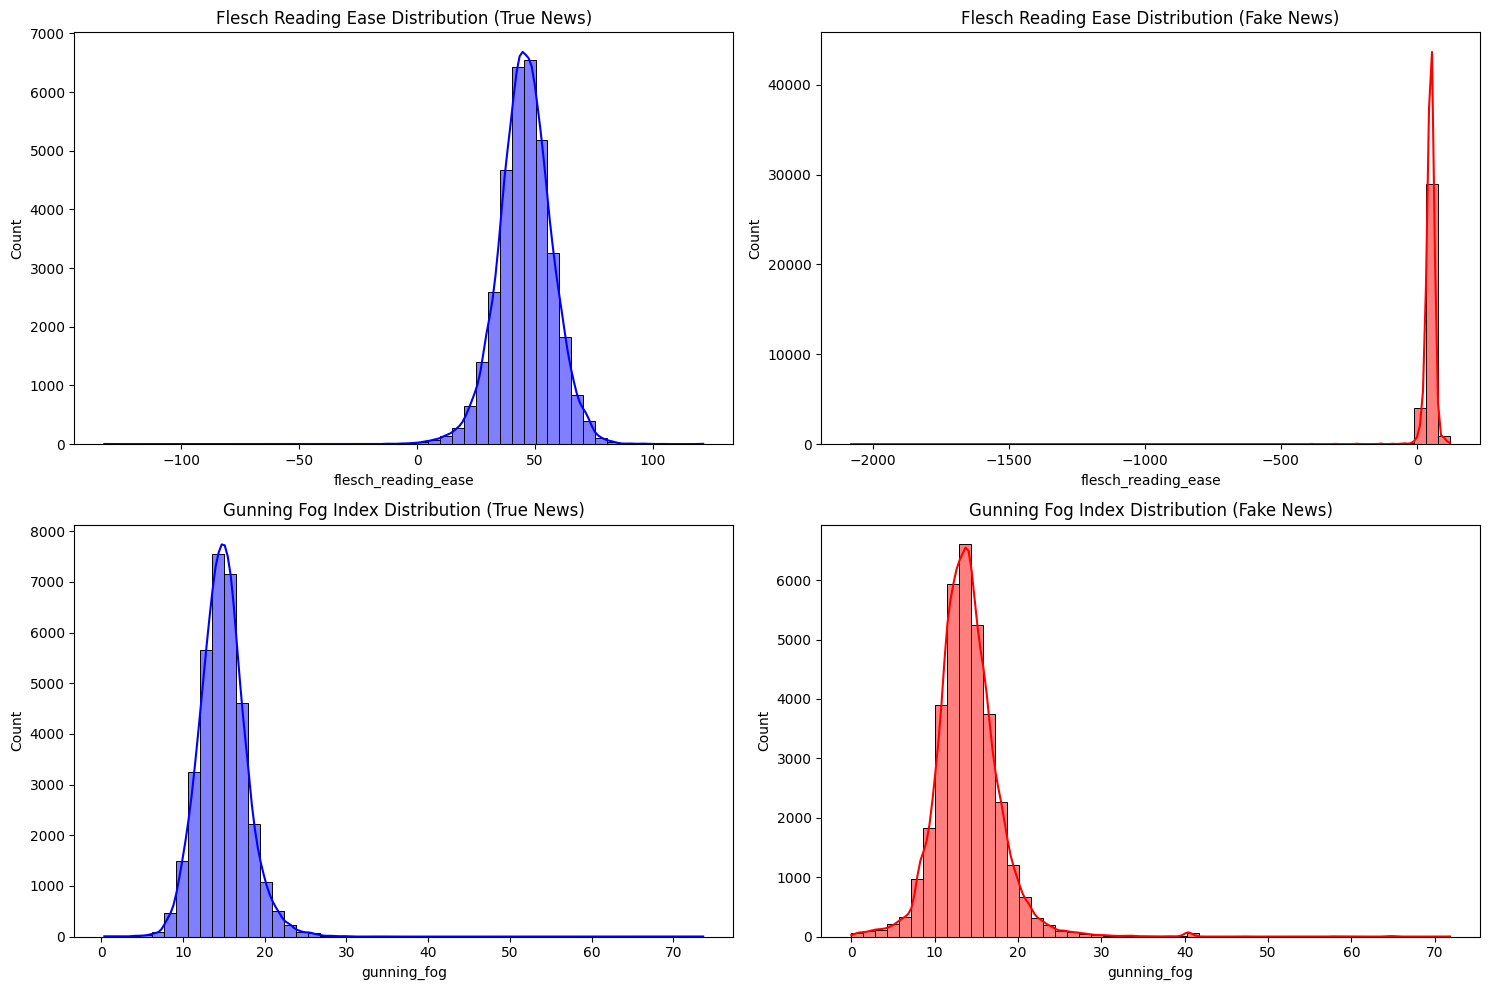

In [45]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

sns.histplot(tmp_true_df['flesch_reading_ease'], bins=50, color='blue', ax=axes[0, 0], kde=True)
axes[0, 0].set_title('Flesch Reading Ease Distribution (True News)')
sns.histplot(tmp_fake_df['flesch_reading_ease'], bins=50, color='red', ax=axes[0, 1], kde=True)
axes[0, 1].set_title('Flesch Reading Ease Distribution (Fake News)')

sns.histplot(tmp_true_df['gunning_fog'], bins=50, color='blue', ax=axes[1, 0], kde=True)
axes[1, 0].set_title('Gunning Fog Index Distribution (True News)')
sns.histplot(tmp_fake_df['gunning_fog'], bins=50, color='red', ax=axes[1, 1], kde=True)
axes[1, 1].set_title('Gunning Fog Index Distribution (Fake News)')

plt.tight_layout()
plt.show()

# Content Analysis

### 1. Word Frequency Analysis

In [49]:
def get_most_common_words(text_series: pd.Series, n: int = 10) -> list:
    """    
    Get the most common words from a Series of text.
    Args:
        text_series (pd.Series): Series containing text data.
        n (int): Number of most common words to return.
    Returns:
        list: List of tuples containing the most common words and their counts.
    """
    all_words = ' '.join(text_series).split()
    counter = Counter(all_words)
    return counter.most_common(n)

In [50]:
true_common_words = get_most_common_words(tmp_true_df['text'], n=30)
fake_common_words = get_most_common_words(tmp_fake_df['text'], n=30)

print("Most Common Words in True News:", true_common_words)
print("Most Common Words in Fake News:", fake_common_words)

Most Common Words in True News: [('the', 964202), ('to', 519024), ('of', 471680), ('a', 435755), ('and', 408694), ('in', 362334), ('that', 218701), ('on', 188742), ('for', 170215), ('is', 141734), ('was', 121976), ('with', 118351), ('The', 110846), ('said', 109750), ('he', 108085), ('as', 104086), ('his', 92180), ('by', 90810), ('has', 87639), ('from', 82175), ('have', 82058), ('at', 81586), ('it', 78060), ('not', 77144), ('be', 75486), ('an', 72874), ('who', 67953), ('are', 65976), ('Mr.', 65152), ('Trump', 63205)]
Most Common Words in Fake News: [('the', 718992), ('to', 402744), ('of', 361727), ('and', 324774), ('a', 283177), ('in', 228607), ('that', 193765), ('is', 166843), ('for', 123707), ('on', 104305), ('s', 97693), ('with', 86868), ('was', 84024), ('as', 77924), ('it', 74969), ('are', 74265), ('be', 71987), ('The', 71734), ('Trump', 70532), ('he', 70152), ('by', 68488), ('have', 67844), ('his', 63163), ('not', 60609), ('has', 60453), ('this', 59265), ('I', 58017), ('from', 5747

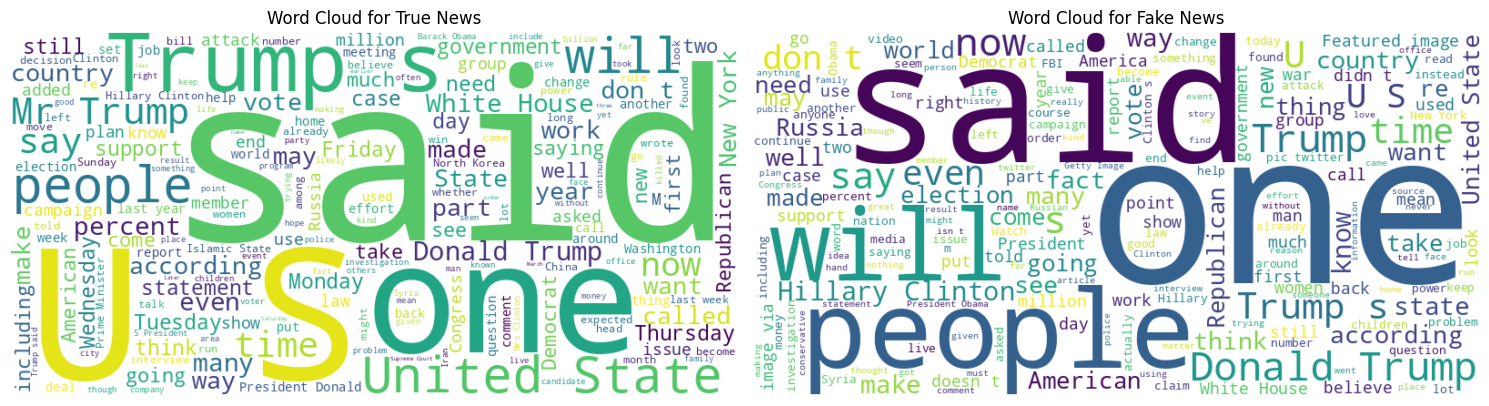

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

true_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(tmp_true_df['text']))
axes[0].imshow(true_wordcloud, interpolation='bilinear')
axes[0].set_title('Word Cloud for True News')
axes[0].axis('off')

fake_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(tmp_fake_df['text']))
axes[1].imshow(fake_wordcloud, interpolation='bilinear')
axes[1].set_title('Word Cloud for Fake News')
axes[1].axis('off')

plt.tight_layout()
plt.show()

### 2. N-grams Analysis

In [ ]:
def plot_ngrams(text_series: pd.Series, ngram_range: tuple = (1, 1), 
                top_n: int = 10, title: str = 'Most Common N-grams', ax=None):
    """
    Plot the most common n-grams in the text data.
    Args:
        text_series (pd.Series): Series containing text data.
        ngram_range (tuple): Range of n-grams (e.g., (2, 2) for bigrams).
        top_n (int): Number of top n-grams to display.
        title (str): Title of the plot.
        ax (matplotlib.axes._subplots.AxesSubplot): Matplotlib axis to plot on.
    """
    
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words='english')
    ngrams = vectorizer.fit_transform(text_series)
    ngram_counts = ngrams.sum(axis=0).A1
    ngram_features = vectorizer.get_feature_names_out()
    ngram_df = pd.DataFrame({'ngram': ngram_features, 'count': ngram_counts})
    ngram_df = ngram_df.sort_values(by='count', ascending=False).head(top_n)
    
    sns.barplot(x='count', y='ngram', data=ngram_df, ax=ax, palette='viridis')
    ax.set_title(title)
    ax.set_xlabel('Count')
    ax.set_ylabel('N-gram')

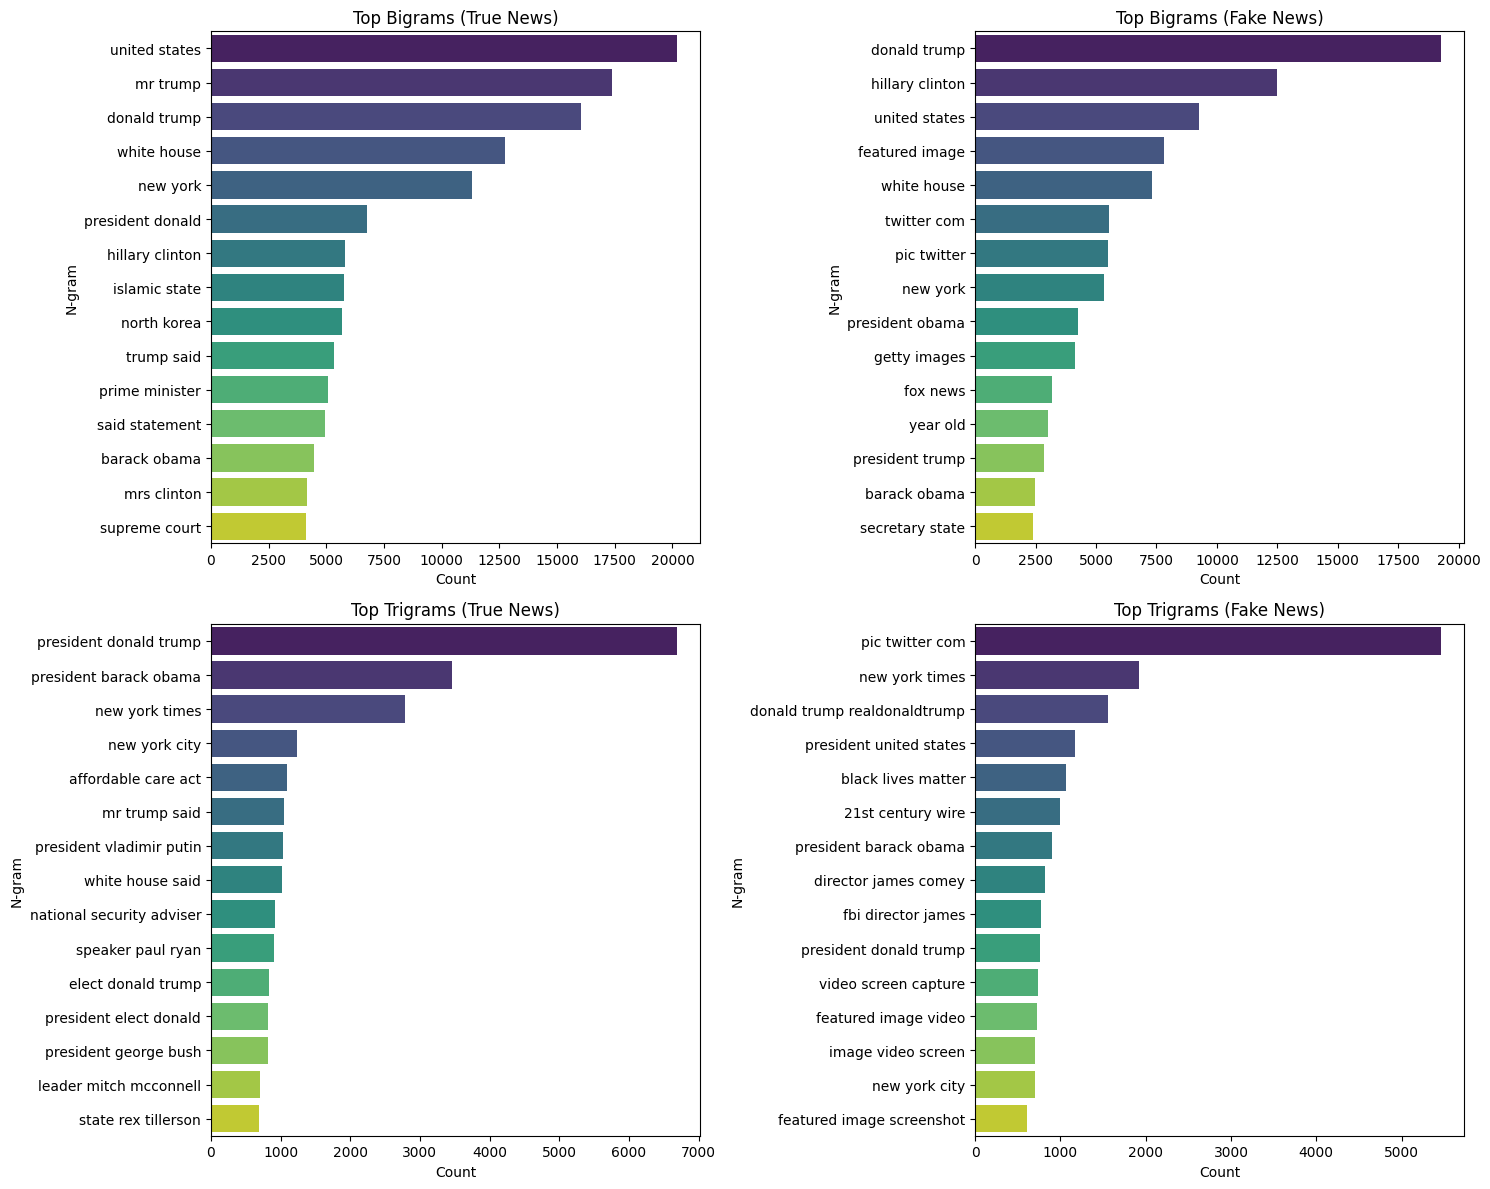

In [53]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

plot_ngrams(tmp_true_df['text'], ngram_range=(2, 2), top_n=15, title='Top Bigrams (True News)', ax=axes[0, 0])
plot_ngrams(tmp_fake_df['text'], ngram_range=(2, 2), top_n=15, title='Top Bigrams (Fake News)', ax=axes[0, 1])

plot_ngrams(tmp_true_df['text'], ngram_range=(3, 3), top_n=15, title='Top Trigrams (True News)', ax=axes[1, 0])
plot_ngrams(tmp_fake_df['text'], ngram_range=(3, 3), top_n=15, title='Top Trigrams (Fake News)', ax=axes[1, 1])

plt.tight_layout()
plt.show()

### 3. TF-IDF

In [110]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')

In [111]:
true_tfidf_matrix = tfidf_vectorizer.fit_transform(tmp_true_df['text'])
true_feature_names = tfidf_vectorizer.get_feature_names_out()

true_tfidf_df = pd.DataFrame(
    true_tfidf_matrix.toarray(),
    columns=true_feature_names,
    index=tmp_true_df.index
)

In [112]:
fake_tfidf_matrix = tfidf_vectorizer.fit_transform(tmp_fake_df['text'])
fake_feature_names = tfidf_vectorizer.get_feature_names_out()

fake_tfidf_df = pd.DataFrame(
    fake_tfidf_matrix.toarray(),
    columns=fake_feature_names,
    index=tmp_fake_df.index
)

In [113]:
true_tfidf_avg = true_tfidf_df.mean().sort_values(ascending=False)
print("Top 20 words in True News by TF-IDF:")
print(true_tfidf_avg.head(20))

fake_tfidf_avg = fake_tfidf_df.mean().sort_values(ascending=False)
print("Top 20 words in Fake News by TF-IDF:")
print(fake_tfidf_avg.head(20))

Top 20 words in True News by TF-IDF:
said          0.088131
trump         0.074724
mr            0.045971
president     0.039163
state         0.030695
people        0.029392
new           0.028926
house         0.027815
government    0.026776
clinton       0.025409
republican    0.024776
states        0.024647
united        0.024019
party         0.022929
year          0.022296
obama         0.021844
told          0.021280
police        0.020294
white         0.020263
election      0.020182
dtype: float64
Top 20 words in Fake News by TF-IDF:
trump        0.086506
clinton      0.035639
people       0.033701
said         0.033699
president    0.031333
russia       0.028901
hillary      0.028197
just         0.025470
obama        0.024321
donald       0.023688
like         0.023684
new          0.021883
ukraine      0.020666
russian      0.020587
state        0.020045
time         0.019571
election     0.019027
white        0.018882
news         0.018604
campaign     0.018252
dtype: floa

### 4. Syntactic Structure Analysis

In [54]:
def create_syntactical_features(df: pd.DataFrame):
    """
    Create syntactical features using spaCy for POS tagging and NER.
    Args:
        df (pd.DataFrame): DataFrame containing the text data.
    Returns:
        pd.DataFrame: DataFrame with additional columns for POS and NER counts.
    """
    
    nlp = spacy.load("en_core_web_sm")

    def process_article(text):
        doc = nlp(text)
        pos_counts = Counter(token.pos_ for token in doc)
        ner_counts = Counter(entity.label_ for entity in doc.ents)
        return pos_counts, ner_counts

    results = df["text"].apply(process_article)
    df["pos_counts"], df["ner_counts"] = zip(*results)

    # Get all unique POS tags and NER labels
    all_pos_tags = set()
    all_ner_labels = set()
    for _, row in df.iterrows():
        all_pos_tags.update(row["pos_counts"].keys())
        all_ner_labels.update(row["ner_counts"].keys())

    for pos_tag in all_pos_tags:
        df[f"pos_{pos_tag}"] = df["pos_counts"].apply(
            lambda x: x[pos_tag] if pos_tag in x else 0
        )

    for ner_label in all_ner_labels:
        df[f"ner_{ner_label}"] = df["ner_counts"].apply(
            lambda x: x[ner_label] if ner_label in x else 0
        )

    df = df.drop(columns=["pos_counts", "ner_counts"])

    return df

In [ ]:
tmp_true_df = create_syntactical_features(true_df)
tmp_fake_df = create_syntactical_features(fake_df)

In [104]:
tmp_true_df

,text,pos_part,pos_propn,pos_adj,pos_sym,pos_punct,pos_space,pos_sconj,pos_verb,pos_adv,...,ner_quantity,ner_cardinal,ner_org,ner_event,ner_work_of_art,ner_person,ner_money,ner_date,ner_law,ner_ordinal
0,Colombia’s peace deal with the Marxist FARC re...,10,43,48,0,46,6,7,47,11,...,0,2,7,0,0,11,0,6,0,0
2,European Council President Donald Tusk cancele...,1,32,10,0,8,2,1,8,0,...,0,0,4,0,0,6,0,5,0,0
3,A Brooklyn man who beat a transgender woman to...,8,30,12,0,50,0,9,54,12,...,0,1,1,0,0,10,0,10,0,0
4,U.S. President Donald Trump voiced caution on ...,1,18,2,0,7,0,2,8,1,...,0,0,2,0,0,5,0,2,0,0
6,U.S. President Donald Trump on Thursday praise...,4,15,7,0,8,5,2,9,0,...,0,1,2,0,0,1,0,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6849,Republican presidential candidate Donald Trump...,12,59,32,0,56,5,5,54,13,...,0,3,6,0,0,7,0,9,0,0
6851,The U.S. Senate’s No. 2 Republican said on Mon...,5,17,6,0,10,0,2,18,5,...,0,1,5,0,0,1,0,4,0,0
6854,"Two weeks ago, Pita Taufatofua gained a sudden...",76,257,202,2,457,46,74,366,141,...,1,25,27,18,1,46,0,22,0,12
6858,Alphabet Inc s Google in the last few months h...,17,85,51,1,54,17,14,86,14,...,0,2,21,0,0,8,1,11,0,1


In [105]:
tmp_fake_df

,text,pos_part,pos_propn,pos_adj,pos_sym,pos_punct,pos_space,pos_sconj,pos_verb,pos_adv,...,ner_quantity,ner_cardinal,ner_org,ner_event,ner_work_of_art,ner_person,ner_money,ner_date,ner_law,ner_ordinal
1,"The ""slow"" countries in a two-speed Europe wil...",0,1,2,0,4,0,0,2,0,...,0,1,0,0,0,0,0,0,0,0
5,Last night s game between the Bears and Packer...,5,28,16,0,17,1,4,31,9,...,0,5,6,0,1,3,0,3,0,0
7,Republican presidential nominee Donald Trump w...,4,25,10,0,24,4,8,35,9,...,0,2,6,0,0,2,0,2,0,0
10,The irony of Donald Trump making a huge speech...,7,39,28,1,30,5,3,39,5,...,0,1,8,0,0,10,1,6,0,0
17,"Donald Trump s campaign manager, Corey Lewando...",15,50,17,0,50,9,12,49,19,...,0,0,9,0,0,20,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6853,Remy Porter Remy escaped the enterprise world ...,54,71,103,0,253,29,22,195,84,...,0,14,11,0,0,42,0,7,0,0
6855,\nJames Marc Leas is a founding member of the...,3,39,2,0,17,3,2,14,2,...,0,2,12,0,1,2,0,3,0,0
6856,Czech TV and Radio are not independent or cred...,1,4,7,0,6,0,0,1,1,...,0,0,1,0,0,0,0,0,0,0
6857,Social media went crazy last night when a phot...,2,1,6,0,3,0,1,6,0,...,0,0,0,0,0,1,0,0,0,0


In [81]:
columns_to_extract = [col for col in tmp_true_df.columns if col.lower().startswith('pos') or col.lower().startswith('ner')]
columns_to_extract

['pos_part',
 'pos_propn',
 'pos_adj',
 'pos_sym',
 'pos_punct',
 'pos_space',
 'pos_sconj',
 'pos_verb',
 'pos_adv',
 'pos_adp',
 'pos_pron',
 'pos_num',
 'pos_cconj',
 'pos_aux',
 'pos_x',
 'pos_det',
 'pos_intj',
 'pos_noun',
 'ner_language',
 'ner_gpe',
 'ner_product',
 'ner_norp',
 'ner_fac',
 'ner_loc',
 'ner_percent',
 'ner_time',
 'ner_quantity',
 'ner_cardinal',
 'ner_org',
 'ner_event',
 'ner_work_of_art',
 'ner_person',
 'ner_money',
 'ner_date',
 'ner_law',
 'ner_ordinal']

In [ ]:
def visualize_pos_ner(df, analysis_type, dataset_name):
    """
    Function to visualize the total counts of Part-of-Speech (POS) tags 
    or Named Entity Recognition (NER) tags from a dataframe.

    Args:
        df (pd.DataFrame): Dataframe containing the data. The columns to analyze
                           must have the prefix 'pos_' or 'ner_'.
        analysis_type (str): Type of analysis, accepts 'pos' or 'ner'.
        dataset_name (str): Name of the dataset (e.g., 'True News' or 'Fake News') 
                            to display in the chart title.
    """
    
    if analysis_type.lower() == 'pos':
        cols_to_sum = [col for col in df.columns if col.startswith('pos_')]
        title_prefix = "POS Tag (Part-of-Speech)"
        xlabel = "Penn Treebank Part-of-Speech Tags"
    elif analysis_type.lower() == 'ner':
        cols_to_sum = [col for col in df.columns if col.startswith('ner_')]
        title_prefix = "NER (Named Entity)"
        xlabel = "Named Entity Recognition Tags"
    else:
        print("Error: The 'analysis_type' parameter must be 'pos' or 'ner'.")
        return

    if not cols_to_sum:
        print(f"Error: No columns with the prefix '{analysis_type.lower()}_' found in the dataframe.")
        return

    data_sum = df[cols_to_sum].sum()
    
    data_sum.index = data_sum.index.str.replace(f'{analysis_type.lower()}_', '', regex=False)
    data_sum = data_sum[data_sum > 0]
    data_sum = data_sum.sort_values(ascending=False)

    plt.style.use('seaborn-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 6))

    sns.barplot(x=data_sum.index, y=data_sum.values, ax=ax)

    ax.set_title(f'{title_prefix} Plot for {len(df)}-Document Corpus ({dataset_name})', fontsize=14)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel('Total Count', fontsize=12)

    plt.xticks(rotation=90)
    
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_35/1522335523.py:44: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


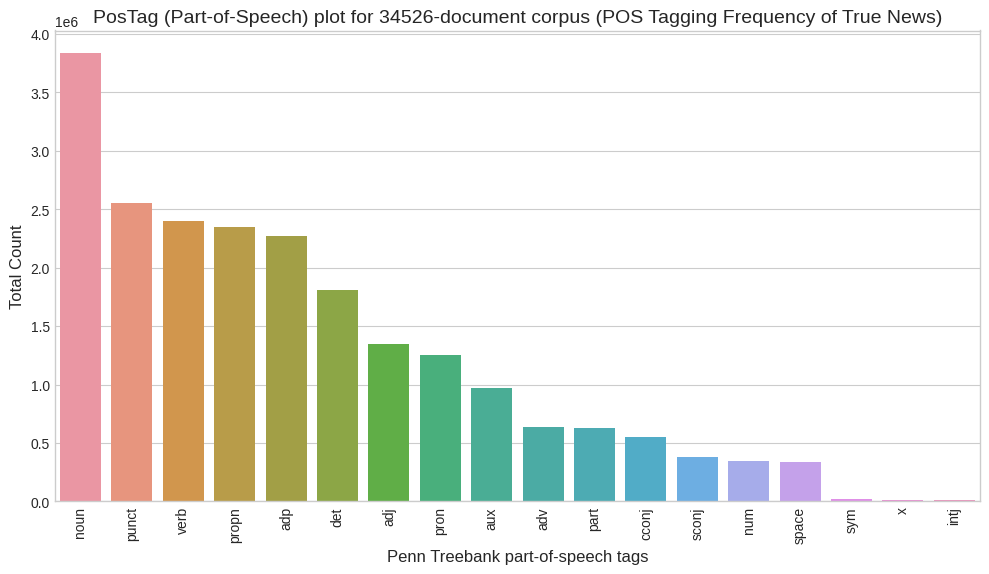

/tmp/ipykernel_35/1522335523.py:44: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


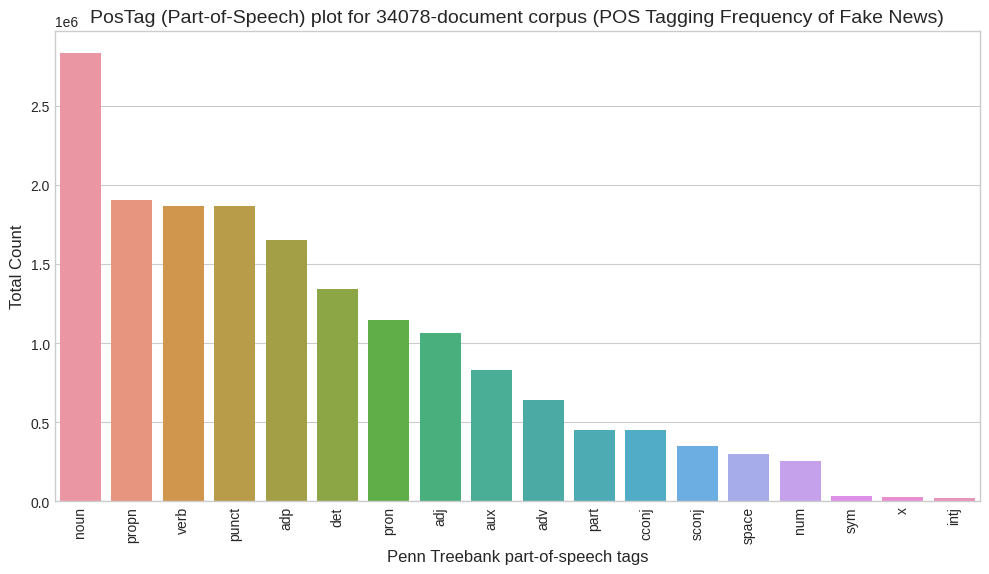

In [107]:
visualize_pos_ner(df=tmp_true_df, type='pos', name='POS Tagging Frequency of True News')
visualize_pos_ner(df=tmp_fake_df, type='pos', name='POS Tagging Frequency of Fake News')

/tmp/ipykernel_35/1522335523.py:44: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


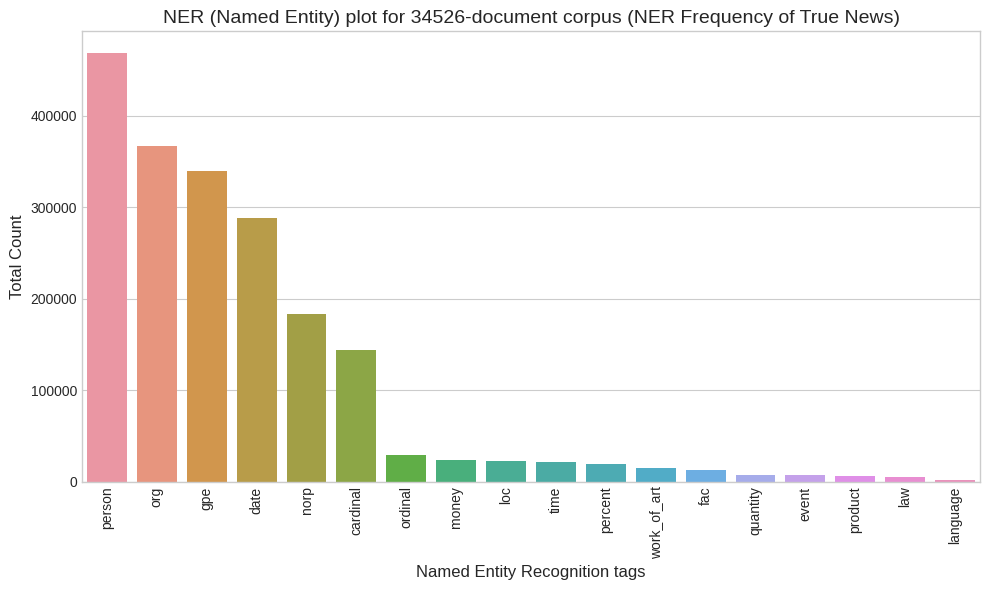

/tmp/ipykernel_35/1522335523.py:44: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


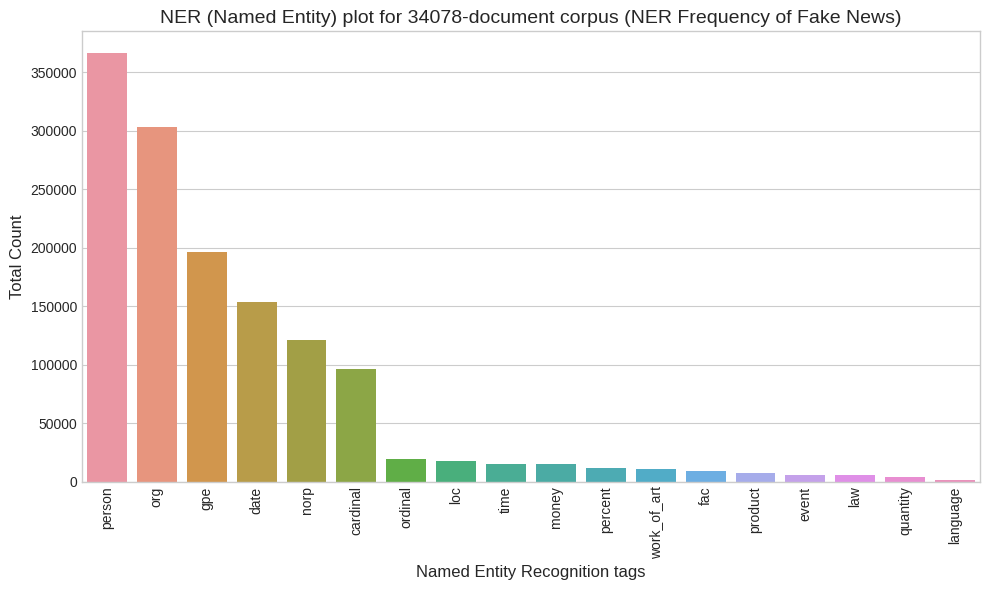

In [108]:
visualize_pos_ner(df=tmp_true_df, type='ner', name='NER Frequency of True News')
visualize_pos_ner(df=tmp_fake_df, type='ner', name='NER Frequency of Fake News')

### 5. Sentiment Analysis

- **VADER (Valence Aware Dictionary and sEntiment Reasoner):** VADER is a lexicon and rule-based sentiment analysis tool specifically designed to recognize sentiment in text, particularly in social media contexts. It calculates a compound score that represents the overall sentiment of the text. The compound score ranges from -1 (extremely negative sentiment) to 1 (extremely positive sentiment).

    VADER is effective for short, informal text and is widely used for analyzing sentiment in tweets, reviews, and other user-generated content.

- **TextBlob:** TextBlob is a Python library for processing textual data. It provides a simple API for common natural language processing tasks, including sentiment analysis. The sentiment polarity score is calculated based on the text's positivity or negativity. The polarity score ranges from -1 (completely negative sentiment) to 1 (completely positive sentiment).
    
    TextBlob is useful for analyzing longer and more formal text. It provides a straightforward way to assess the sentiment polarity of a document or sentence.

In [ ]:
def create_sentiment_features(df: pd.DataFrame):
    """
    Create sentiment features using VADER and TextBlob.
    There are two sentiment analysis methods used:
    1. VADER (Valence Aware Dictionary and sEntiment Reasoner)
    2. TextBlob
    Args:
        df (pd.DataFrame): DataFrame containing the text data.
    Returns:
        pd.DataFrame: DataFrame with additional columns for sentiment scores.
    """
    
    def get_vader_sentiment(text):
        analyzer = SentimentIntensityAnalyzer()
        vs = analyzer.polarity_scores(text)
        return vs["compound"]

    def get_textblob_sentiment(text):
        blob = TextBlob(text)
        return blob.sentiment.polarity

    df["vader_sentiment"] = df["text"].apply(get_vader_sentiment)
    df["textblob_sentiment"] = df["text"].apply(get_textblob_sentiment)
    return df

In [ ]:
tmp_true_df = create_sentiment_features(tmp_true_df)
tmp_fake_df = create_sentiment_features(tmp_fake_df)

In [120]:
tmp_true_df

,text,vader_sentiment,textblob_sentiment
0,Colombia’s peace deal with the Marxist FARC re...,0.9906,0.160974
2,European Council President Donald Tusk cancele...,0.1280,-0.035714
3,A Brooklyn man who beat a transgender woman to...,-0.9883,-0.113462
4,U.S. President Donald Trump voiced caution on ...,0.5927,0.080000
6,U.S. President Donald Trump on Thursday praise...,0.9708,0.205455
...,...,...,...
6849,Republican presidential candidate Donald Trump...,-0.9412,0.014286
6851,The U.S. Senate’s No. 2 Republican said on Mon...,0.8442,0.100000
6854,"Two weeks ago, Pita Taufatofua gained a sudden...",0.9997,0.082282
6858,Alphabet Inc s Google in the last few months h...,-0.9983,0.032837


In [121]:
tmp_fake_df

,text,vader_sentiment,textblob_sentiment
1,"The ""slow"" countries in a two-speed Europe wil...",-0.4019,-0.185714
5,Last night s game between the Bears and Packer...,-0.9646,0.014255
7,Republican presidential nominee Donald Trump w...,-0.7734,-0.058730
10,The irony of Donald Trump making a huge speech...,-0.9431,-0.010666
17,"Donald Trump s campaign manager, Corey Lewando...",-0.8287,0.162884
...,...,...,...
6853,Remy Porter Remy escaped the enterprise world ...,0.9678,0.010404
6855,\nJames Marc Leas is a founding member of the...,-0.5346,0.166667
6856,Czech TV and Radio are not independent or cred...,0.1531,0.100000
6857,Social media went crazy last night when a phot...,0.1027,0.022222


In [122]:
tmp_true_df.describe()

,vader_sentiment,textblob_sentiment
count,34526.000000,34526.000000
mean,0.109927,0.061255
std,0.838794,0.094210
min,-1.000000,-1.000000
25%,-0.895700,0.009562
50%,0.402600,0.061772
75%,0.959175,0.110358
max,1.000000,1.000000


In [123]:
tmp_fake_df.describe()

,vader_sentiment,textblob_sentiment
count,34078.000000,34078.000000
mean,-0.067620,0.054426
std,0.806286,0.130789
min,-1.000000,-1.000000
25%,-0.927875,0.000000
50%,-0.160600,0.050652
75%,0.870500,0.114168
max,1.000000,1.000000


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

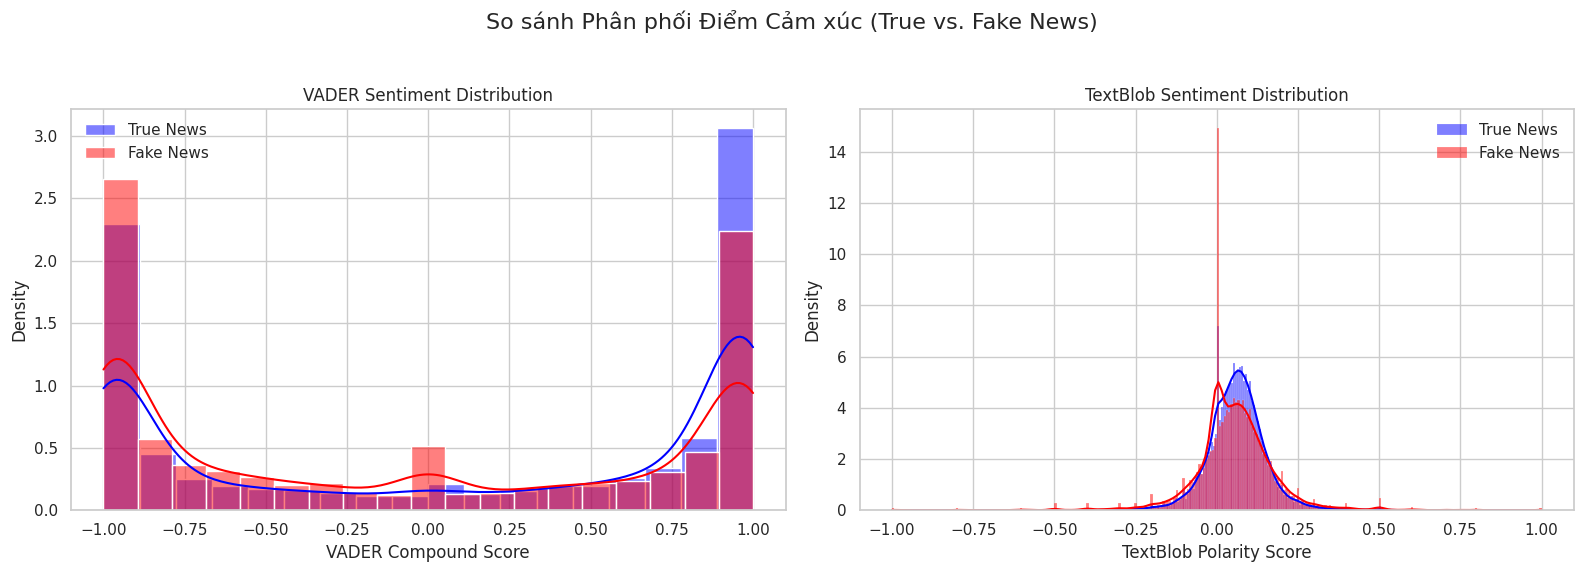

In [ ]:
sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('So sánh Phân phối Điểm Cảm xúc (True vs. Fake News)', fontsize=16)

sns.histplot(tmp_true_df['vader_sentiment'], color='blue', label='True News', kde=True, ax=axes[0], stat="density", common_norm=False)
sns.histplot(tmp_fake_df['vader_sentiment'], color='red', label='Fake News', kde=True, ax=axes[0], stat="density", common_norm=False)
axes[0].set_title('VADER Sentiment Distribution')
axes[0].set_xlabel('VADER Compound Score')
axes[0].legend()

sns.histplot(tmp_true_df['textblob_sentiment'], color='blue', label='True News', kde=True, ax=axes[1], stat="density", common_norm=False)
sns.histplot(tmp_fake_df['textblob_sentiment'], color='red', label='Fake News', kde=True, ax=axes[1], stat="density", common_norm=False)
axes[1].set_title('TextBlob Sentiment Distribution')
axes[1].set_xlabel('TextBlob Polarity Score')
axes[1].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

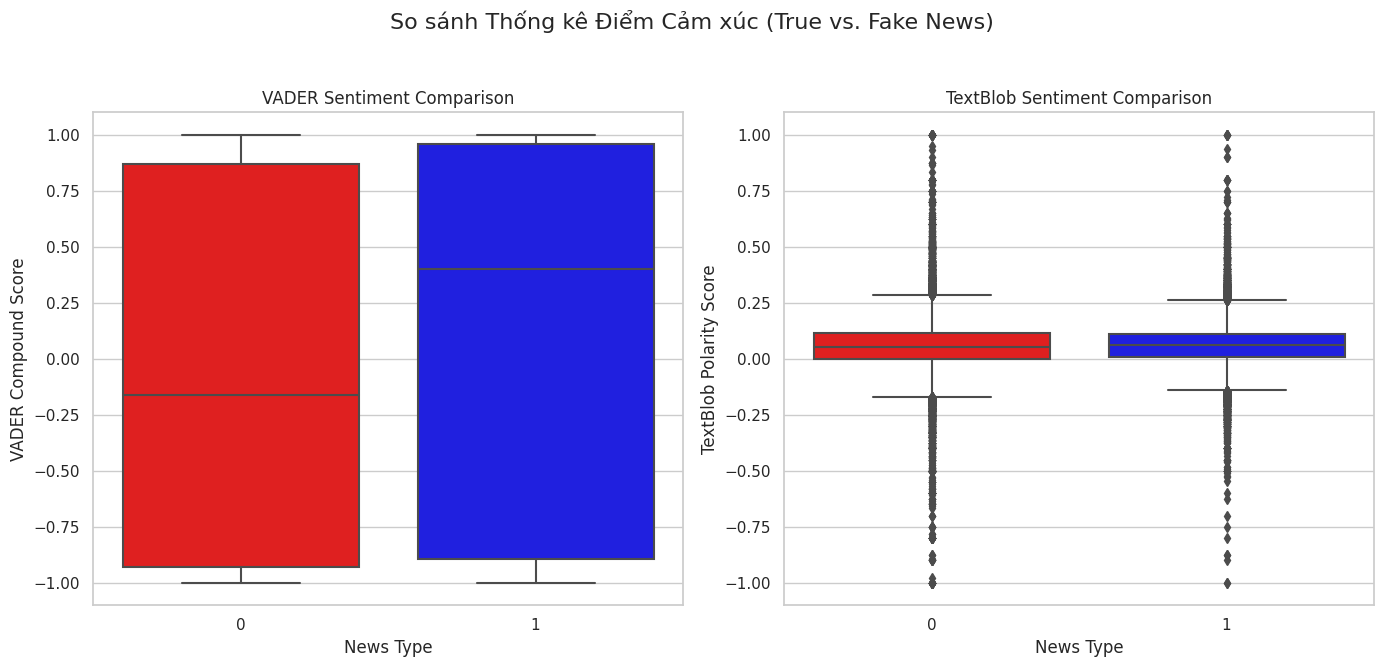

In [127]:
tmp_true_df['label'] = 1
tmp_fake_df['label'] = 0
combined_df = pd.concat([tmp_true_df, tmp_fake_df], ignore_index=True)

fig, axes = plt.subplots(1, 2, figsize=(14, 7))
fig.suptitle('So sánh Thống kê Điểm Cảm xúc (True vs. Fake News)', fontsize=16)

sns.boxplot(x='label', y='vader_sentiment', data=combined_df, ax=axes[0], palette=['red', 'blue'])
axes[0].set_title('VADER Sentiment Comparison')
axes[0].set_xlabel('News Type')
axes[0].set_ylabel('VADER Compound Score')

sns.boxplot(x='label', y='textblob_sentiment', data=combined_df, ax=axes[1], palette=['red', 'blue'])
axes[1].set_title('TextBlob Sentiment Comparison')
axes[1].set_xlabel('News Type')
axes[1].set_ylabel('TextBlob Polarity Score')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Data Splitting

In [150]:
from sklearn.model_selection import train_test_split

In [ ]:
true_df["label"] = 1
fake_df["label"] = 0

In [ ]:
combined_df = pd.concat([true_df, fake_df], ignore_index=True)

In [ ]:
combined_df['text'] = combined_df['text'].apply(preprocess_text)
combined_df = create_lexical_features(combined_df)
combined_df = create_syntactical_features(combined_df)
combined_df = create_sentiment_features(combined_df)
combined_df['flesch_reading_ease'] = combined_df['text'].apply(textstat.flesch_reading_ease)
combined_df['gunning_fog'] = combined_df['text'].apply(textstat.gunning_fog)

In [151]:
train_stratified, test_stratified = train_test_split(
    combined_df,
    test_size=0.1,
    random_state=42,
    stratify=combined_df["label"],
)

In [ ]:
train_stratified.to_csv("./data/stratify_train.csv")
test_stratified.to_csv("./data/stratify_test.csv")